In [1]:
from pynwb import NWBHDF5IO
#from nwbwidgets import nwb2widget
import h5py, glob, os
import numpy as np
import matplotlib.pyplot as plt
from dlab import sglx_analysis as sglx
from dlab import psth_and_raster as pr
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm as tqdm
import glob
import pickle as pkl
import json
import datetime as dt
import h5py
from dlab import sglx_analysis as sglx
# import jlh_ephys as jlh
import matplotlib.pyplot as plt
# from open_ephys.analysis import Session
import seaborn as sns




In [178]:
class Eopn3_Ephys:

    def __init__(self,nwb_path):
        self.nwb_path = nwb_path
        self.nwb = None
        self.load_nwb()
        self.structure = StructureData(self)
        self.plotter = Eopn3_Plotter(self, self)
      

    def nwb(self):
        if self.nwb is None:
            self.load_nwb()
        return self.nwb

    def load_nwb(self):
        nwb_path = self.nwb_path
        io = NWBHDF5IO(nwb_path, 'r')
        nwb = io.read()
        self.nwb = nwb
        return self.nwb
    
    def trials(self):
        nwb = self.nwb
        trials_df = nwb.trials.to_dataframe()
        trials_df.loc[2100:2699,'contacts'] = '10r'  #specific to this recording, fixes an error in dataframe
        self.trials_df = trials_df

        return trials_df
    
    def units(self):
        nwb = self.nwb
        units_df = nwb.units.to_dataframe()
        self.units_df = units_df
        return units_df
    


In [176]:
class StructureData(Eopn3_Ephys):

    
    def __init__(self,eopn3_ephys):
         self.eopn3_ephys = eopn3_ephys
         self.plotter = Eopn3_Plotter(self.eopn3_ephys, self)
         trials_df = self.eopn3_ephys.trials()
         units_df = self.eopn3_ephys.units()

    def optogenetics_time_windows(self):
         optogenetics_on = []
         trials_df = self.trials_df
         for index, value in trials_df.iterrows():
             if value["optogenetics_LED_state"] == 1:
                  optogenetics_on.append(index)

         self.optogenetics_on = optogenetics_on
         return optogenetics_on
              
                  
                  
              


In [177]:

class Eopn3_Plotter(Eopn3_Ephys):
      
    # def __init__(self, eopn3_ephys,StructureData):
    #     self.StructureData = StructureData
    #     self.Eopn3_Ephys = eopn3_ephys  # Store the instance
    #     self.units = self.eopn3_ephys.units()  # Store units as an instance attribute
    #     self.trials = self.eopn3_ephys.trials()  # Store trials as an instance attribute
    #     self.time_windows = self.StructureData.optogenetics_time_windows() 


    def __init__(self, eopn3_ephys, StructureData):
        self.StructureData = StructureData
        self.eopn3_ephys = eopn3_ephys  # Store the instance with the correct name
        self.units = self.eopn3_ephys.units()
        self.trials = self.eopn3_ephys.trials()
        self.time_windows = self.StructureData.optogenetics_time_windows() 

        # ...

    def optogenetic_on_psth(self):
        optogenetics_on = self.optogenetics_on
        trials_df = self.trials_df

        plt.figure(figsize=(10, 6))
        i = 0
        for index, row in trials_df.iterrows():
            if index == optogenetics_on[i]:
                spike_times = row['spike_times']
                neuron_numbers = [index] * len(spike_times)
                plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
                i += 1
        plt.show()


    def all_psth(self):
        plt.figure(figsize=(10, 6))
        # We will iterate over each row (neuron) in the DataFrame
        for index, row in self.units.iterrows():
        
            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']

            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        # After plotting all neurons' spikes, display the plot
        plt.show()
         
 
    def psth_time_window(self, start_time, stop_time):
        self.trials()
        units_df = self.units() 
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():  # use units_df directly
            
            # Each row's 'spike_times' column contains the array of spike times
            # We filter these spike times based on the start_time and stop_time
            spike_times = [time for time in row['spike_times'] if start_time <= time <= stop_time]
            

            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the filtered spike_times array
            neuron_numbers = [index] * len(spike_times)

            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots
        plt.show()

    def single_neuron_psth(self, neuron_index):
        units_df = self.units() 
        self.trials()
        # self.parameters()
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this is not the selected neuron, skip it
            if index != neuron_index:
                continue

            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']

            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        # After plotting the selected neuron's spikes, display the plot
        plt.show()

    def multi_neuron_psth(self, neuron_indices):
        units_df = self.units() 
        self.trials()
        plt.figure(figsize=(10, 6))

        # We will iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this neuron is not in the list of selected neurons, skip it
            if index not in neuron_indices:
                continue

            # Each row's 'spike_times' column contains the array of spike times
            spike_times = row['spike_times']
            # We create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the spike_times array
            neuron_numbers = [index] * len(spike_times)
            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        # After plotting the selected neurons' spikes, display the plot
        plt.show()


    def multi_neuron_time_psth(self, neuron_indices, time_window):
        self.trials()
        units_df = self.units()
        plt.figure(figsize=(10, 6))
        start_time, stop_time = time_window

        # Iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # If this neuron is not in the list of selected neurons, skip it
            if index not in neuron_indices:
                continue

            # Each row's 'spike_times' column contains the array of spike times
            # We filter these spike times based on the start_time and stop_time
            spike_times = [time for time in row['spike_times'] if start_time <= time <= stop_time]
            
            # Create a y-coordinate array filled with the current index (neuron number),
            # with the same length as the filtered spike_times array
            neuron_numbers = [index] * len(spike_times)

            # Create a scatter plot for this neuron's spike times
            plt.scatter(spike_times, neuron_numbers, s=1)  # s sets the size of the dots

        # After plotting all neurons' spikes, display the plot
        plt.show()

    def all_raster(self):
        units_df = self.units() 
        self.trials()
        plt.figure(figsize=(10, 6))
        
        # Empty lists to store neuron indices and their spike counts
        neuron_indices = []
        spike_counts = []
        
        # Iterate over each row (neuron) in the DataFrame
        for index, row in units_df.iterrows():
            # Append the neuron index and its spike count to the respective lists
            neuron_indices.append(index)
            spike_counts.append(len(row['spike_times']))

        # Generate a raster plot with neuron indices on x-axis and spike counts on y-axis
        plt.bar(neuron_indices, spike_counts)
        
        # Set the plot title and labels
        plt.title("Neuron Spike Counts")
        plt.xlabel("Neuron Index")
        plt.ylabel("Spike Count")

        # Display the plot
        plt.show()

    import numpy as np

    def firing_frequency_distribution(self, num_bins=10):
        units_df = self.units() 
        self.trials()
        plt.figure(figsize=(10, 6))

        # Calculate the firing frequency for each neuron (spike count / trial duration)
        firing_frequencies = [len(row['spike_times']) / self.trials()['start_time'].max() for _, row in units_df.iterrows()]

        # Bin the neurons based on their firing frequencies
        bins = np.linspace(min(firing_frequencies), max(firing_frequencies), num_bins)
        neuron_bins = np.digitize(firing_frequencies, bins)

        # Count the number of neurons in each bin
        bin_counts = np.bincount(neuron_bins)

        # Generate a raster plot with neuron bins on x-axis and firing frequency on y-axis
        plt.bar(range(1, len(bin_counts)), bin_counts[1:])  # Ignore the first bin (it will contain all neurons with zero frequency)

        # Set the plot title and labels
        plt.title("Firing Frequency Distribution")
        plt.xlabel("Neuron Bins")
        plt.ylabel("Firing Frequency")

        # Display the plot
        plt.show()

    def get_run_time_windows(self):
        trials_df = self.trials()

        # Find the first 'start_time' and last 'stop_time' across all rows
        run_time_windows = {
            'start_time': trials_df['start_time'].min(),
            'stop_time': trials_df['stop_time'].max()
        }

        return run_time_windows


    def plot_run_window(self, run_number):
        units_df = self.units()
        run_time_windows = self.get_run_time_windows()

        # Create a figure for your plot (you can customize the size)
        plt.figure(figsize=(10, 6))

        for index, row in units_df.iterrows():
            # Filter the spike times based on the start_time and stop_time
            spike_times = [time for time in row['spike_times'] if run_time_windows['start_time'] <= time <= run_time_windows['stop_time']]

            # Assuming you want to plot spike times for each neuron
            y = [index] * len(spike_times)
            plt.scatter(spike_times, y)

        # Additional code to customize the plot (axes labels, title, etc.) if needed
        plt.xlabel('Time')
        plt.ylabel('Neuron Number')
        plt.title('Spike Times Plot')
        plt.show()

In [179]:
nwb_path = "/Users/grant/Documents/coding/neural_data/eOPN3_46.nwb"

eopn3 = Eopn3_Ephys(nwb_path)


AttributeError: 'StructureData' object has no attribute 'trials_df'

In [169]:
eopn3.plotter.optogenetic_on_psth()

AttributeError: 'Eopn3_Plotter' object has no attribute 'optogenetics_on'

In [144]:
eopn3.trials_df

AttributeError: 'Eopn3_Ephys' object has no attribute 'trials_df'

In [40]:
eopn3.structure.optogenetics_time_windows()

[2,
 5,
 8,
 9,
 10,
 14,
 15,
 17,
 18,
 20,
 21,
 22,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 37,
 38,
 39,
 43,
 47,
 52,
 53,
 54,
 55,
 58,
 61,
 62,
 64,
 68,
 69,
 70,
 72,
 74,
 78,
 80,
 82,
 83,
 86,
 87,
 90,
 92,
 96,
 97,
 98,
 99]

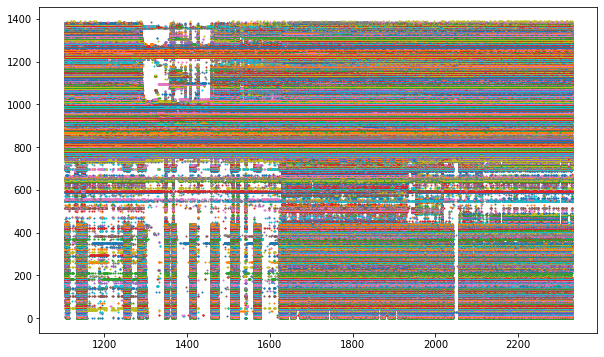

In [9]:
eopn3.plotter.all_psth()

In [84]:
eopn3.units()

,depth,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,spike_times,electrodes,waveform_mean
id,,,,,,,,,,,
0,1013.195409,30.683947,3795.195409,0,1,1016.1,100.2,A,"[1109.4048936263537, 1109.818320648671, 1110.2...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,938.338041,31.053864,3720.338041,0,1,883.9,80.4,A,"[1108.9367264189364, 1108.938428117146, 1110.3...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,983.547308,27.801565,3765.547308,0,1,513.9,43.3,A,"[1107.0035413375556, 1107.0217915700377, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,925.189943,29.911659,3707.189943,0,1,922.2,244.3,A,"[1104.5537168053509, 1106.3120356802092, 1107....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,973.527915,33.743584,3755.527915,2,2,1129.2,7.4,A,"[1107.0476822106343, 1108.0015932361373, 1108....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
1384,-2333.371572,26.729427,471.628428,0,1,684.9,0.0,C,"[1134.154436008208, 1508.7308162236252, 1522.1...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1385,-1154.576101,45.339119,1650.423899,1,2,831.3,100.0,C,"[1116.516382634238, 1119.405341263333, 1121.69...",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1386,-1984.479906,15.740321,820.520094,0,1,1249.9,0.0,C,"[1142.7195634904638, 1166.3699626412435, 1170....",location ...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


[1109.40489363 1109.81832065 1110.2971998  ... 2330.41289321 2330.41452655
 2330.41629321]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

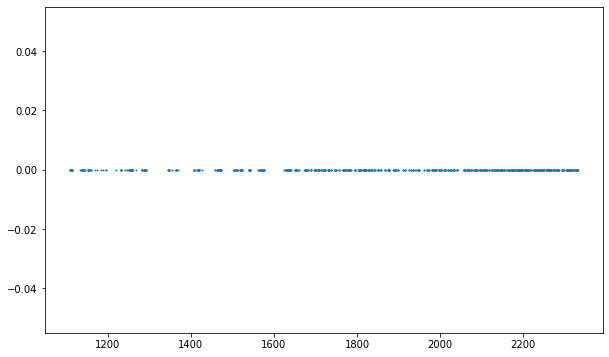

In [70]:
eopn3.all_psth()

In [61]:
# eopn3.trials()

In [42]:
# eopn3.units()

In [46]:
# eopn3.firing_frequency_distribution()

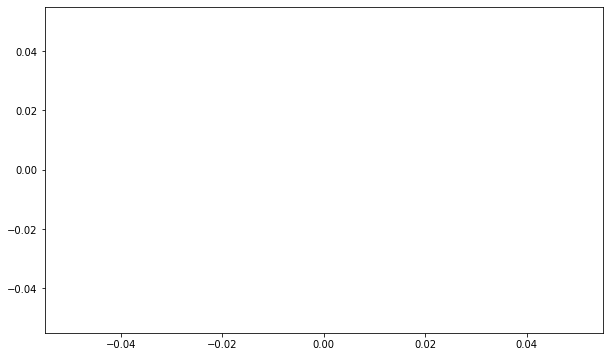

In [50]:
eopn3.multi_neuron_time_psth([],[1600,1610])

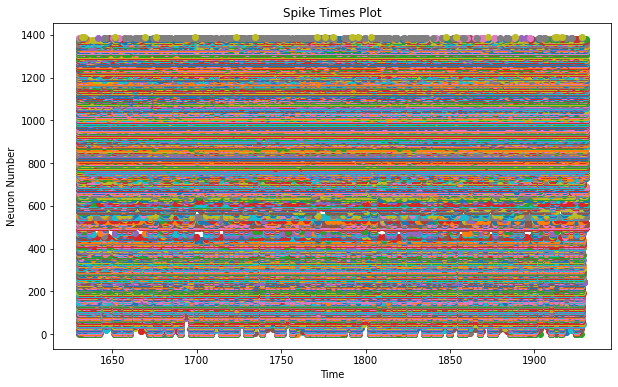

In [47]:
eopn3.plot_run_window(4)

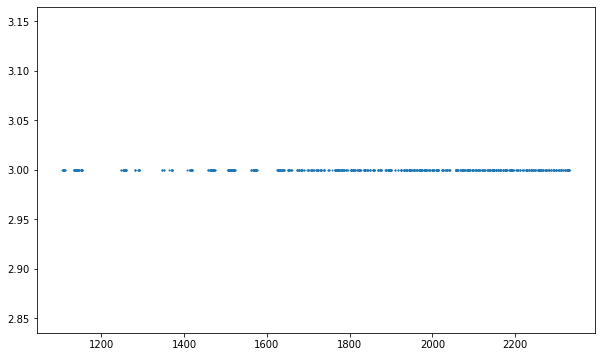

In [16]:
eopn3.single_neuron_psth(3)

In [17]:
eopn3.all_psth()

AttributeError: 'DataFrame' object has no attribute 'run'